In [9]:
#!unzip "./TodosComics.zip" -d "./"

Archive:  ./TodosComics.zip
  inflating: ./TodosComics.csv       


# IMPORTS

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [26]:
comics = pd.read_csv("TodosComics.csv", index_col=0)
#characters = pd.read_csv("TodosPersonagens.csv", index_col=0)
creators = pd.read_csv("TodosCreators.csv", index_col=0)
#events = pd.read_csv("TodosEvents.csv", index_col=0)
#series = pd.read_csv("TodosSeries.csv", index_col=0)

# INSIGHTS

In [ ]:
characters

,id,name,description,modified,resourceURI,urls,thumbnail.path,thumbnail.extension,comics.available,comics.collectionURI,...,series.items,series.returned,stories.available,stories.collectionURI,stories.items,stories.returned,events.available,events.collectionURI,events.items,events.returned
0,1011334,3-D Man,NaN,2014-04-29T14:18:17+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/c/e0/53...,jpg,12,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,3,21,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,1,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,1
1,1017100,A-Bomb (HAS),Rick Jones has been Hulk's best bud since day ...,2013-09-18T15:54:04+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/3/20/52...,jpg,4,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,7,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,7,0,https://gateway.marvel.com/v1/public/character...,[],0
2,1009144,A.I.M.,AIM is a terrorist organization bent on destro...,2013-10-17T14:41:30+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/6/20/52...,jpg,53,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,61,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,0,https://gateway.marvel.com/v1/public/character...,[],0
3,1010699,Aaron Stack,NaN,1970-01-01T00:00:00+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,jpg,14,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,3,28,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,0,https://gateway.marvel.com/v1/public/character...,[],0
4,1009146,Abomination (Emil Blonsky),"Formerly known as Emil Blonsky, a spy of Sovie...",2014-06-27T19:39:07+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/9/50/4c...,jpg,55,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,68,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,1,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1559,1011515,Zeus,Zeus ruled a peaceful Olympus for centuries wh...,2021-08-18T22:06:56+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/f/60/4c...,png,36,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,13,43,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,0,https://gateway.marvel.com/v1/public/character...,[],0
1560,1011127,Zodiak,"Twelve demons merged with Norman Harrison, who...",1970-01-01T00:00:00+0000,https://gateway.marvel.com/v1/public/character...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,jpg,1,https://gateway.marvel.com/v1/public/character...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,1,1,https://gateway.marvel.com/v1/public/character...,[{'resourceURI': 'https://gateway.marvel.com/v...,1

In [ ]:
comics

,id,digitalId,title,issueNumber,variantDescription,description,modified,isbn,upc,diamondCode,...,characters.items,characters.returned,stories.available,stories.collectionURI,stories.items,stories.returned,events.available,events.collectionURI,events.items,events.returned
0,82967,0,Marvel Previews (2017),0.0,NaN,NaN,2019-11-07T08:46:15+0000,NaN,75960608839302811,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0
1,82965,0,Marvel Previews (2017),0.0,NaN,NaN,2019-08-21T17:11:27+0000,NaN,75960608839302611,JUL190068,...,[],0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0
2,82970,52952,Marvel Previews (2017),0.0,NaN,NaN,2020-02-07T09:35:32+0000,NaN,75960608839303111,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/82...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/82...,[],0
3,61137,0,The Punisher (2016) #5 (Cosplay Variant),5.0,Cosplay Variant,NaN,2016-09-01T12:40:16+0000,NaN,75960608413500521,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/61...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/61...,[],0
4,37497,0,MARVELS (1994) #1,1.0,NaN,NaN,2014-05-08T12:18:55+0000,NaN,NaN,NaN,...,[],0,0,https://gateway.marvel.com/v1/public/comics/37...,[],0,0,https://gateway.marvel.com/v1/public/comics/37...,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64263,21671,0,Psi-Force (1986) #28,28.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0
64264,21672,0,Psi-Force (1986) #29,29.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0
64265,21674,0,Psi-Force (1986) #30,30.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0
64266,21675,0,Psi-Force (1986) #31,31.0,NaN,NaN,-0001-11-30T00:00:00+0000,NaN,NaN,NaN,...,[],0,2,https://gateway.marvel.com/v1/public/comics/21...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/comics/21...,[],0


## Colunas NaN

In [ ]:
Nan_relation = {}
for col in comics.columns:
  Nan_relation[col] = comics[col].isna().sum()

df = pd.DataFrame(list(Nan_relation.items()), columns=['Colunas', 'Quantidade'])
df = df[df["Quantidade"] > 0]

fig = px.bar(df, x='Colunas', y='Quantidade',
             color="Colunas",
             template="presentation",
             labels={'Colunas': 'Colunas', 'Quantidade': 'Frequência de Nulos'},
             title="Quantidade de valores nulos por coluna em Comics")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

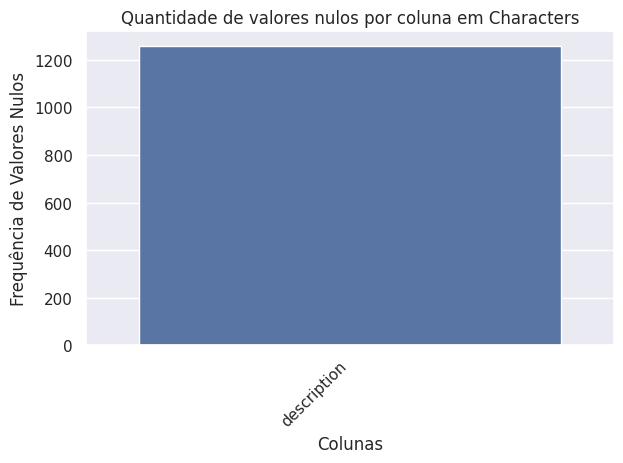

In [ ]:
Nan_relation = {}
for col in characters.columns:
  Nan_relation[col] = characters[col].isna().sum()

df = pd.DataFrame(list(Nan_relation.items()), columns=['Colunas', 'Quantidade'])
df = df[df["Quantidade"] > 0]

sns.set_theme()
sns.barplot(data=df, x="Colunas", y="Quantidade")
plt.xlabel("Colunas")
plt.ylabel("Frequência de Valores Nulos")
plt.title("Quantidade de valores nulos por coluna em Characters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
characters["last_modified"] = characters["modified"].str.split('-').str[0]
personagens_modificados = characters["last_modified"].value_counts().reset_index()
personagens_modificados.columns = ["Ano", "Quantidade"]

media_pessimista = abs(personagens_modificados["Quantidade"].mean() - personagens_modificados["Quantidade"].std())

personagens_modificados[personagens_modificados["Quantidade"] > media_pessimista]

fig = px.bar(personagens_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Characters")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [49]:
comics["last_modified"] = comics["modified"].str.split('-').str[0]
comics_modificados = comics["last_modified"].value_counts().reset_index()
comics_modificados.columns = ["Ano", "Quantidade"]

media = abs(comics_modificados["Quantidade"].mean())

comics_modificados[comics_modificados["Quantidade"] > media]

fig = px.bar(comics_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Comics")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## PERSONAGENS COM APARIÇÃO ACIMA DA MÉDIA

In [ ]:
most_comics_characters = characters[characters["comics.available"] > characters["comics.available"].mean()]

In [ ]:
media_de_aparicao = characters["comics.available"].mean()

In [ ]:
print(f"Existem {len(most_comics_characters)} personagens, com aparições acima da média (acima de {int(media_de_aparicao)} aparições)")

Existem 280 personagens, com aparições acima da média (acima de 65 aparições)


In [ ]:
print("Personagens que mais aparecem")
most_comics_characters[["name", "description", "comics.available", "stories.available",  "events.available"]].sort_values("comics.available", ascending=False).head(10).reset_index(drop=True)

Personagens que mais aparecem


,name,description,comics.available,stories.available,events.available
0,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",4533,6588,37
1,X-Men,Feared and hated by humans because they're dif...,4113,5820,43
2,Wolverine,Born with super-human senses and the power to ...,2761,3811,44
3,Iron Man,"Wounded, captured and forced to build a weapon...",2745,4098,31
4,Captain America,"Vowing to serve his country any way he could, ...",2545,3723,30
5,Avengers,Earth's Mightiest Heroes joined forces to take...,2298,3129,32
6,Thor,"As the Norse God of thunder and lightning, Tho...",1903,2827,27
7,Hulk,Caught in a gamma bomb explosion while trying ...,1777,2710,26
8,Fantastic Four,"After being exposed to cosmic rays, Reed Richa...",1564,2437,24
9,Daredevil,"Abandoned by his mother, Matt Murdock was rais...",1286,1994,17


In [ ]:
print("Personagens que menos aparecem")
most_comics_characters[["name", "description", "comics.available", "stories.available",  "events.available"]].sort_values("comics.available", ascending=True).head(10).reset_index(drop=True)

Personagens que menos aparecem


,name,description,comics.available,stories.available,events.available
0,Spider-Man (Ben Reilly),NaN,66,68,1
1,Penance (Robert Baldwin),NaN,66,84,6
2,Omega Red,NaN,66,76,1
3,Spider-Ham (Larval Earth),As Spider-Ham Peter faced such nefarious foes ...,67,68,0
4,Fantomex,NaN,67,74,4
5,Dum Dum Dugan,NaN,67,84,3
6,Storm (Ultimate),"Ororo Munroe was raised in Morocco, learning E...",67,122,0
7,Cyclops (Ultimate),NaN,67,121,0
8,Iceman (Ultimate),NaN,67,118,0
9,Annihilus,NaN,67,85,1


In [ ]:
nao_possuem_desc = len(most_comics_characters[most_comics_characters["description"].isna()])
possuem_desc = len(most_comics_characters[~most_comics_characters["description"].isna()])

print(f"A quantidade de personagens que têm a descrição nula é: {nao_possuem_desc}")
print(f"A quantidade de personagens que não têm a descrição nula é: {possuem_desc}")

A quantidade de personagens que têm a descrição nula é: 205
A quantidade de personagens que não têm a descrição nula é: 75


In [ ]:
most_comics_characters["Has_Desc"] = most_comics_characters["description"].apply(lambda x: 0 if pd.isna(x) else 1)

<ipython-input-107-a5472f3b1012>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



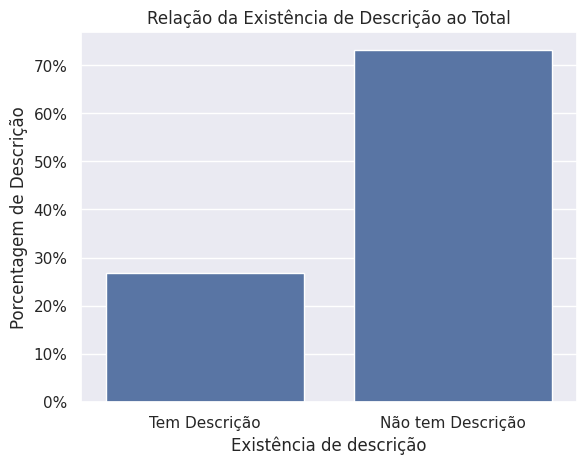

In [ ]:
sns.barplot(x=["Tem Descrição", "Não tem Descrição"], y=[(possuem_desc/len(most_comics_characters))*100, (nao_possuem_desc/len(most_comics_characters))*100])
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.title("Relação da Existência de Descrição ao Total")
plt.show()

In [ ]:
corr_cols = round(float(most_comics_characters["Has_Desc"].corr(most_comics_characters["comics.available"])),2)
print(f"A correlação entre ter descrição e a quantidade de quadrinhos disponíveis deste personagem é de {corr_cols}")

A correlação entre ter descrição e a quantidade de quadrinhos disponíveis deste personagem é de 0.27


In [117]:
aux = 1
price_year = pd.DataFrame(columns=["Preco", "Ano"])
for year in comics["last_modified"].unique():
  for price in comics[comics["last_modified"] == year]["prices"].values:
    #aux = comics[comics["last_modified"] == year]["prices"][1]
    aux = price
    aux = aux.strip("[]")
    aux = aux.split("'price':")[1]
    aux = aux.strip("}")
    aux = aux.split(" ")[1]
    aux = aux.split("}")[0]
    aux = float(aux)

    price_year.loc[len(price_year)] = [aux, year]
#aux

In [129]:
media_precos = price_year.groupby("Ano")["Preco"].mean().reset_index()
media_precos_maior_zero = price_year[price_year["Preco"] > 0].groupby("Ano")["Preco"].mean().reset_index()

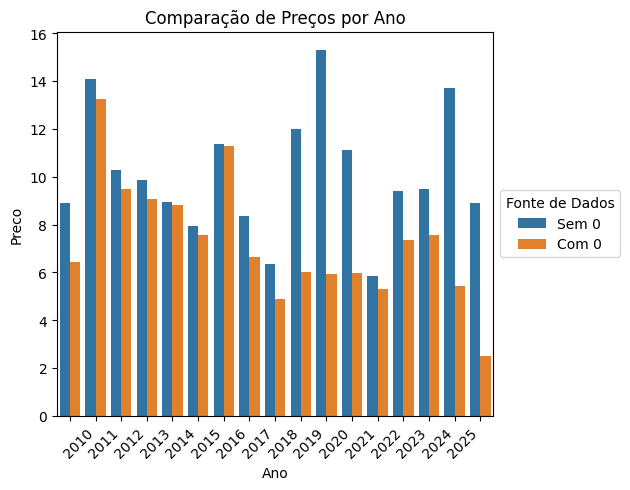

In [140]:
medias_merged = media_precos.merge(media_precos_maior_zero, on='Ano', suffixes=('_com0', '_sem0'))

df_long = medias_merged.melt(id_vars='Ano', value_vars=['Preco_sem0', 'Preco_com0'],
                         var_name='Fonte', value_name='Preco')

df_long['Fonte'] = df_long['Fonte'].replace({
    'Preco_sem0': 'Sem 0',
    'Preco_com0': 'Com 0'
})

sns.barplot(data=df_long, x='Ano', y='Preco', hue='Fonte')
plt.title("Comparação de Preços por Ano")
plt.legend(title="Fonte de Dados", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

In [142]:
media_historias = comics.groupby("last_modified")["stories.available"].mean().reset_index()
media_historias

,last_modified,stories.available
0,,2.674595
1,2010,2.525926
2,2011,2.043408
3,2012,1.957520
4,2013,2.171458
5,2014,1.986509
6,2015,2.019868
7,2016,2.108935
8,2017,2.506300
9,2018,2.593542


In [143]:
media_historias

,last_modified,stories.available
0,,2.674595
1,2010,2.525926
2,2011,2.043408
3,2012,1.957520
4,2013,2.171458
5,2014,1.986509
6,2015,2.019868
7,2016,2.108935
8,2017,2.506300
9,2018,2.593542


<Axes: xlabel='creators.available', ylabel='Density'>

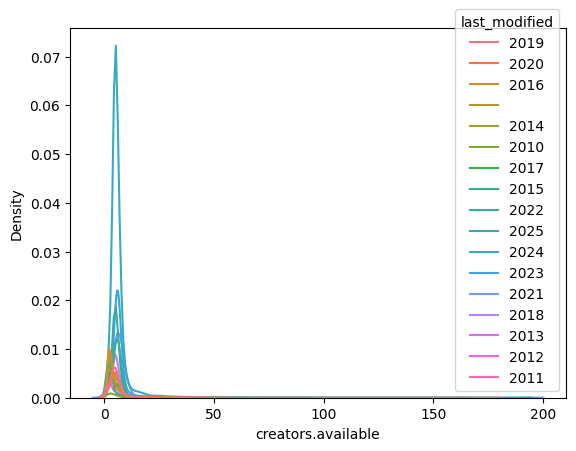

In [71]:
sns.kdeplot(data=comics[comics["creators.available"] > 0], x="creators.available", hue="last_modified")

In [27]:
creators = creators[~creators["fullName"].isna()]

In [34]:
cols = ["fullName", "events.available", "stories.available"]
most_events = creators[cols].sort_values("events.available", ascending=False).head(25)
most_events

,fullName,events.available,stories.available
955,Vc Joe Caramagna,29,12553
2095,Scott Hanna,21,2051
1362,Frank D'ARMATA,21,2680
3791,Vc Cory Petit,20,8984
3630,Tom Palmer,19,1176
1680,Vc Chris Eliopoulos,19,2435
1402,Peter David,18,1718
1808,Christos Gage,18,1086
4193,John Romita Jr.,18,2012
904,Virtual Calligr,17,885


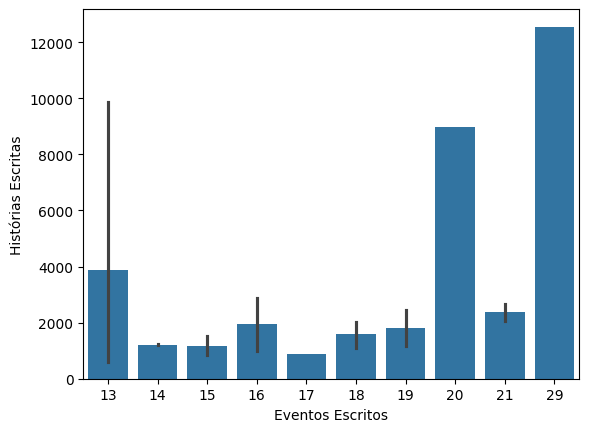

In [43]:
sns.barplot(data=most_events, x="events.available", y="stories.available")
plt.xlabel("Eventos Escritos")
plt.ylabel("Histórias Escritas")
plt.show()

In [35]:
cols = ["fullName", "stories.available", "events.available"]
most_stories = creators[cols].sort_values("stories.available", ascending=False).head(25)
most_stories

,fullName,stories.available,events.available
5282,Jeff Youngquist,17934,8
955,Vc Joe Caramagna,12553,29
726,Tom Brevoort,9861,13
3791,Vc Cory Petit,8984,20
3645,Mark Paniccia,8917,10
1290,Vc Clayton Cowles,8910,11
3112,Nick Lowe,7630,13
3403,Wilson Moss,5770,3
2848,Vc Travis Lanham,5708,5
4210,Vc Joe Sabino,5501,5


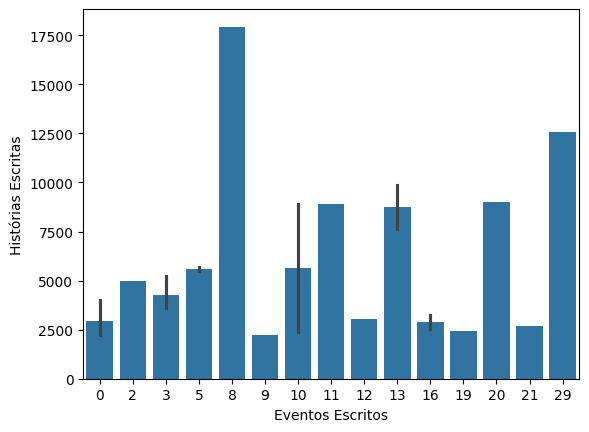

In [44]:
sns.barplot(data=most_stories, x="events.available", y="stories.available")
plt.xlabel("Eventos Escritos")
plt.ylabel("Histórias Escritas")
plt.show()

In [36]:
stories_index = most_stories.index
events_index = most_events.index
combined = []
for author in stories_index:
  if author in events_index:
    combined.append(author)
len(combined)

7

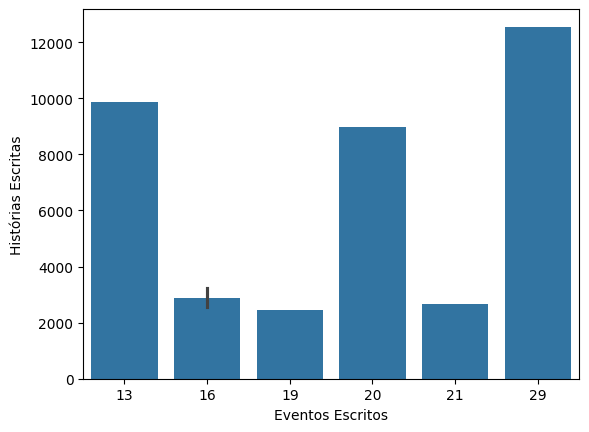

In [45]:
sns.barplot(data=most_stories.loc[combined], x="events.available", y="stories.available")
plt.xlabel("Eventos Escritos")
plt.ylabel("Histórias Escritas")
plt.show()

In [38]:
most_stories.loc[combined]

,fullName,stories.available,events.available
955,Vc Joe Caramagna,12553,29
726,Tom Brevoort,9861,13
3791,Vc Cory Petit,8984,20
4513,Richard Starkings,3236,16
1362,Frank D'ARMATA,2680,21
515,Brian Michael Bendis,2551,16
1680,Vc Chris Eliopoulos,2435,19


In [41]:
combined

[955, 726, 3791, 4513, 1362, 515, 1680]

In [46]:
creators

,id,firstName,middleName,lastName,suffix,fullName,modified,resourceURI,urls,thumbnail.path,...,series.items,series.returned,stories.available,stories.collectionURI,stories.items,stories.returned,events.available,events.collectionURI,events.items,events.returned
23,13970,#O,NaN,NaN,NaN,#O,2019-12-11T17:10:07+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,4,3,https://gateway.marvel.com/v1/public/creators/...,[{'resourceURI': 'https://gateway.marvel.com/v...,3,0,https://gateway.marvel.com/v1/public/creators/...,[],0
24,13971,#X,NaN,NaN,NaN,#X,2019-12-11T17:21:29+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,4,4,https://gateway.marvel.com/v1/public/creators/...,[{'resourceURI': 'https://gateway.marvel.com/v...,4,0,https://gateway.marvel.com/v1/public/creators/...,[],0
25,11422,a,NaN,NaN,NaN,a,2010-12-02T17:43:05+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0
26,6606,A.R.K.,NaN,NaN,NaN,A.R.K.,2007-01-01T00:00:00+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0
27,13659,Alan,Simon,NaN,NaN,Alan Simon,2019-03-21T09:52:18+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5327,14364,Chrissie,NaN,Zullo,NaN,Chrissie Zullo,2025-05-08T09:19:55+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,46,https://gateway.marvel.com/v1/public/creators/...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,0,https://gateway.marvel.com/v1/public/creators/...,[],0
5328,3697,Joel,NaN,Zulueta,NaN,Joel Zulueta,2007-01-01T00:00:00+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,1,1,https://gateway.marvel.com/v1/public/creators/...,[{'resourceURI': 'https://gateway.marvel.com/v...,1,0,https://gateway.marvel.com/v1/public/creators/...,[],0
5329,6505,Antony,De,Zuniga,NaN,Antony De Zuniga,2010-11-23T09:53:50+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0,0,https://gateway.marvel.com/v1/public/creators/...,[],0
5330,14035,Christina,NaN,Zuniga,NaN,Christina Z,2025-04-19T10:40:28+0000,https://gateway.marvel.com/v1/public/creators/...,"[{'type': 'detail', 'url': 'http://marvel.com/...",http://i.annihil.us/u/prod/marvel/i/mg/b/40/im...,...,[{'resourceURI': 'https://gateway.marvel.com/v...,3,9,https://gateway.marvel.com/v1/public/creators/...,[{'resourceURI': 'https://gateway.marvel.com/v...,9,0,https://gateway.marvel.com/v1/public/creators/...,[],0


In [21]:
creators.iloc[0,-7]

'https://gateway.marvel.com/v1/public/creators/12728/stories'

In [11]:
creators.columns

Index(['id', 'firstName', 'middleName', 'lastName', 'suffix', 'fullName',
       'modified', 'resourceURI', 'urls', 'thumbnail.path',
       'thumbnail.extension', 'comics.available', 'comics.collectionURI',
       'comics.items', 'comics.returned', 'series.available',
       'series.collectionURI', 'series.items', 'series.returned',
       'stories.available', 'stories.collectionURI', 'stories.items',
       'stories.returned', 'events.available', 'events.collectionURI',
       'events.items', 'events.returned'],
      dtype='object')